**IT-Jim trainee program Task 1.**

Author: Artur Pelcharskyi

In [1]:
import os
import torch
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from imagededup.methods import PHash
from imagededup.utils import plot_duplicates
from facenet_pytorch import MTCNN

from tqdm import tqdm
from typing import List, Tuple
from utils import generate_dataframe, add_images_size, show_10_images

/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = "./trainee_dataset"
train_path = os.path.join(dataset_path, "train")
test_path  = os.path.join(dataset_path, "test")

In [3]:
df_train = generate_dataframe(train_path)
df_test  = generate_dataframe(test_path)

In [4]:
df_train

frame_index           filename  \
0          00389  image_00389_1.png   
1          01202  image_01202_1.png   
2          00654  image_00654_1.png   
3          00164  image_00164_1.png   
4          00001  image_00001_1.png   
...          ...                ...   
1795       00826  image_00826_1.png   
1796       01441  image_01441_1.png   
1797       01356  image_01356_1.png   
1798       01180  image_01180_1.png   
1799       00667  image_00667_1.png   

                                      file_path  label  
0     ./trainee_dataset/train/image_00389_1.png      1  
1     ./trainee_dataset/train/image_01202_1.png      1  
2     ./trainee_dataset/train/image_00654_1.png      1  
3     ./trainee_dataset/train/image_00164_1.png      1  
4     ./trainee_dataset/train/image_00001_1.png      1  
...                                         ...    ...  
1795  ./trainee_dataset/train/image_00826_1.png      1  
1796  ./trainee_dataset/train/image_01441_1.png      1  
1797  ./trainee_dataset/train/image_01356_1.png      1  
1798  ./trainee_dataset/train/image_01180_1.png      1  
1799  ./trainee_dataset/train/image_00667_1.png      1  

[1800 rows x 4 columns]

# EDA

Let's examine the class distribution in the dataset.

In [5]:
total_artefacts = df_train[df_train['label'] == 0].shape[0]
total_artefactless = df_train[df_train['label'] == 1].shape[0]

plt.figure(figsize=(6, 4))
plt.bar([0, 1], [total_artefacts, total_artefactless], alpha=0.7, label='Unique')
plt.title("Class Distribution")
plt.xlabel("Label (0 = Artefact, 1 = Artefactless)")
plt.ylabel("Count")
plt.xticks([0, 1], ['Artefact', 'Artefactless'])
plt.show()

We can see that the dataset is imbalanced, with a 1:9 ratio between the classes. This is a crucial factor in solving the problem, as models tend to favor the dominant class. In this case, under standard conditions, the model would benefit from always predicting the "Artefactless" class, achieving a 90% micro F1-score. To avoid this, it's necessary to apply techniques that account for class imbalance.

Next, we need to inspect the image metadata. We already know that all images in the `df_train` and `df_test` tables can be read, since the function skips invalid images. Now let’s check whether all the images have the same dimensions.

In [6]:
add_images_size(df_train)
df_train

frame_index           filename  \
0          00389  image_00389_1.png   
1          01202  image_01202_1.png   
2          00654  image_00654_1.png   
3          00164  image_00164_1.png   
4          00001  image_00001_1.png   
...          ...                ...   
1795       00826  image_00826_1.png   
1796       01441  image_01441_1.png   
1797       01356  image_01356_1.png   
1798       01180  image_01180_1.png   
1799       00667  image_00667_1.png   

                                      file_path  label  width  height  
0     ./trainee_dataset/train/image_00389_1.png      1   1024    1024  
1     ./trainee_dataset/train/image_01202_1.png      1   1024    1024  
2     ./trainee_dataset/train/image_00654_1.png      1   1024    1024  
3     ./trainee_dataset/train/image_00164_1.png      1   1024    1024  
4     ./trainee_dataset/train/image_00001_1.png      1   1024    1024  
...                                         ...    ...    ...     ...  
1795  ./trainee_dataset/train/image_00826_1.png      1   1024    1024  
1796  ./trainee_dataset/train/image_01441_1.png      1   1024    1024  
1797  ./trainee_dataset/train/image_01356_1.png      1   1024    1024  
1798  ./trainee_dataset/train/image_01180_1.png      1   1024    1024  
1799  ./trainee_dataset/train/image_00667_1.png      1   1024    1024  

[1800 rows x 6 columns]

In [7]:
df_train[['width', 'height']].dropna().drop_duplicates()

width  height
0   1024    1024

We see that all images are 1024x1024 pixels, which allows us to avoid unnecessary resizing.

Typically, several images are generated at once so that the best one can be selected. Therefore, it is reasonable to assume that the dataset might contain duplicates — images with the same backgrounds, faces, or color palettes. However, for better training performance, it is desirable to have a diverse dataset with minimal duplication. Let’s check if our dataset contains duplicates.

To do this, we will use the PHash method provided by the `imagededup` library. It uses Discrete Cosine Transform (DCT) to generate hash values for each image and compares them to find similar ones. Images with similar hash values are considered duplicates.

In [8]:
phasher = PHash()
encodings = phasher.encode_images(image_dir=train_path)
duplicates = phasher.find_duplicates(encoding_map=encodings)

2025-04-15 18:44:53,692: INFO Start: Calculating hashes...
100%|██████████| 1800/1800 [00:24<00:00, 73.45it/s] 
2025-04-15 18:45:18,413: INFO End: Calculating hashes!
/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/imagededup/methods/hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)
2025-04-15 18:45:18,415: INFO Start: Evaluating hamming distances for getting duplicates
2025-04-15 18:45:18,416: INFO Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 1800/1800 [00:00<00:00, 2735.06it/s]
2025-04-15 18:45:19,222: INFO End: Retrieving duplicates using Cython Brute force algorithm
2025-04-15 18:45:19,223: INFO End: Evaluating hamming distances for getting duplicates


In [9]:
duplicates_num = []
for key, val in duplicates.items():
    duplicates_num.append((len(val), key))
duplicates_num = sorted(duplicates_num)

duplicate_files = set()
for _, file in duplicates_num:
    if file not in duplicate_files:
        duplicate_files.update(duplicates[file])

Now the `duplicate_files` dictionary stores the duplicate images — the key is the image name, and the value is a list of its duplicates. Let's take a look at some examples of images with the highest number of duplicates.

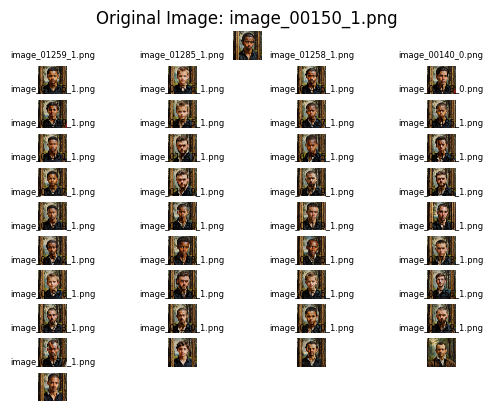

In [10]:
plot_duplicates(image_dir=train_path,
                duplicate_map=duplicates,
                filename=duplicates_num[-1][1])

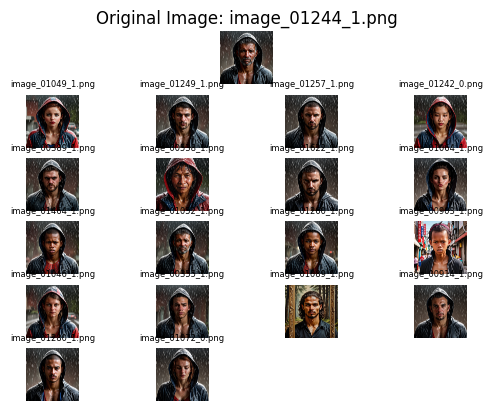

In [11]:
plot_duplicates(image_dir=train_path,
                duplicate_map=duplicates,
                filename=duplicates_num[-100][1])

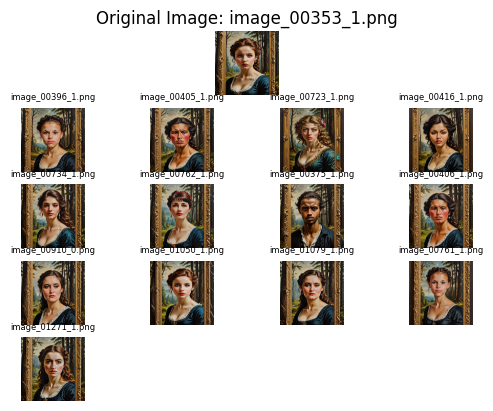

In [12]:
plot_duplicates(image_dir=train_path,
                duplicate_map=duplicates,
                filename=duplicates_num[-200][1])

As we can see, the assumption was correct — many images share the same background (e.g., a frame), or clothing (e.g., a black jacket). Therefore, we will create a new dataset that contains only unique images.



Next, let’s check how many duplicates were found in total and how many images remain for training after removing them.

In [13]:
df_train_unique = df_train[~df_train['filename'].isin(duplicate_files)]
df_train_unique

frame_index           filename  \
2          00654  image_00654_1.png   
4          00001  image_00001_1.png   
5          00503  image_00503_1.png   
7          00681  image_00681_1.png   
8          01573  image_01573_1.png   
...          ...                ...   
1793       00612  image_00612_1.png   
1795       00826  image_00826_1.png   
1796       01441  image_01441_1.png   
1797       01356  image_01356_1.png   
1798       01180  image_01180_1.png   

                                      file_path  label  width  height  
2     ./trainee_dataset/train/image_00654_1.png      1   1024    1024  
4     ./trainee_dataset/train/image_00001_1.png      1   1024    1024  
5     ./trainee_dataset/train/image_00503_1.png      1   1024    1024  
7     ./trainee_dataset/train/image_00681_1.png      1   1024    1024  
8     ./trainee_dataset/train/image_01573_1.png      1   1024    1024  
...                                         ...    ...    ...     ...  
1793  ./trainee_dataset/train/image_00612_1.png      1   1024    1024  
1795  ./trainee_dataset/train/image_00826_1.png      1   1024    1024  
1796  ./trainee_dataset/train/image_01441_1.png      1   1024    1024  
1797  ./trainee_dataset/train/image_01356_1.png      1   1024    1024  
1798  ./trainee_dataset/train/image_01180_1.png      1   1024    1024  

[994 rows x 6 columns]

In [14]:
i = 0
unique_artefacts = 0
unique_artefactless = 0

while i < len(duplicates_num) and duplicates_num[i][0] == 0:
    label = int(duplicates_num[i][1][:-4].split("_")[-1])
    if label == 0:
        unique_artefacts += 1
    else:
        unique_artefactless += 1
    i += 1

Unique/Without duplicates/All artefact images: 79/129/180
Unique rate: 43.89%, Without duplicates rate: 71.67%

Unique/Without duplicates/All images: 358/865/1620
Unique rate: 22.10%, Without duplicates rate: 53.40%



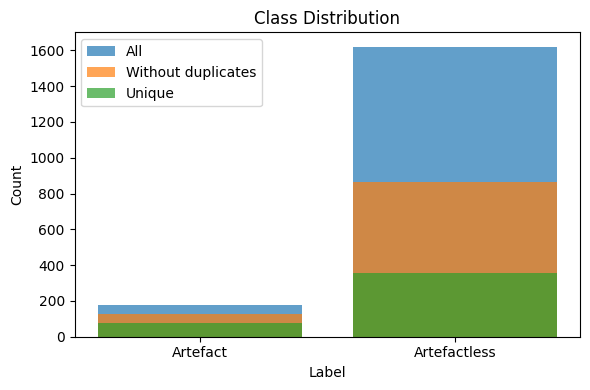

In [64]:
artefacts_without_dupl = df_train_unique[df_train_unique['label'] == 0].shape[0]
artefactsless_without_dupl = df_train_unique[df_train_unique['label'] == 1].shape[0]

print(f"Unique/Without duplicates/All artefact images: {unique_artefacts}/{artefacts_without_dupl}/{total_artefacts}\n\
Unique rate: {unique_artefacts / total_artefacts * 100:.2f}%, Without duplicates rate: {artefacts_without_dupl / total_artefacts * 100:.2f}%\n")
print(f"Unique/Without duplicates/All images: {unique_artefactless}/{artefactsless_without_dupl}/{total_artefactless}\n\
Unique rate: {unique_artefactless / total_artefactless * 100:.2f}%, Without duplicates rate: {artefactsless_without_dupl / total_artefactless * 100:.2f}%\n")


plt.figure(figsize=(6, 4))
plt.bar([0, 1], [total_artefacts, total_artefactless], alpha=0.7, label='All')
plt.bar([0, 1], [artefacts_without_dupl, artefactsless_without_dupl], alpha=0.7, label='Without duplicates')
plt.bar([0, 1], [unique_artefacts, unique_artefactless], alpha=0.7, label='Unique')

plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks([0, 1], ['Artefact', 'Artefactless'])
plt.legend()

plt.tight_layout()

It turns out that "Artefactless" images have a higher proportion of duplicates compared to "Artefact" images. By removing the duplicates, we slightly improve the class balance, at the cost of reducing the overall dataset size.

Note:

    Unique refers to images that have no duplicates at all.

    Without duplicates refers to a deduplicated set where, from each group of duplicates, only one image is retained. This set is used to form the new training dataset.

## Faces

Since we don’t want to lose valuable training data, in one of the approaches we will explore a way to utilize the entire dataset while minimizing the impact of duplicates. As we observed earlier, duplicates typically share common backgrounds or clothing, while the faces are often different. Therefore, we can attempt to extract only the faces from all images and create a new dataset composed of cropped facial regions.

To detect and extract faces from the images, I used [FaceNet](https://github.com/timesler/facenet-pytorch).

In [16]:
mtcnn = MTCNN(keep_all=True, device="cuda")

def detect_face(image_path: str, scale_factor: float = 0, square: bool = False) -> Tuple[np.ndarray, int]:
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    boxes, _ = mtcnn.detect(img)
    if boxes is not None:
        areas = [(box[2] - box[0]) * (box[3] - box[1]) for box in boxes]
        largest_idx = np.argmax(areas)
        box = boxes[largest_idx]
        coord0, coord1, coord2, coord3 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        if coord0 < 0 or coord1 < 0 or coord2 < 0 or coord3 < 0:
            return img, 0

        height = int(coord3 - coord1)
        width = int(coord2 - coord0)
        if square:
            if height > width:
                coord1 = int(coord1 - height * scale_factor)
                coord3 = int(coord3 + height * scale_factor)
                diff = coord3 - coord1 - (coord2 - coord0) 
                if diff % 2 == 1:
                    coord2 += 1
                coord0 -= diff // 2
                coord2 += diff // 2
            else:
                coord0 = int(coord0 - width * scale_factor)
                coord2 = int(coord2 + width * scale_factor)
                diff = coord2 - coord0 - (coord3 - coord1) 
                if diff % 2 == 1:
                    coord3 += 1
                coord1 -= diff // 2
                coord3 += diff // 2
        else:
            coord0 = int(coord0 - width * scale_factor)
            coord1 = int(coord1 - height * scale_factor)
            coord2 = int(coord2 + width * scale_factor)
            coord3 = int(coord3 + height * scale_factor)

        face = img[int(coord1):int(coord3), int(coord0):int(coord2)]
        return face, 1
    else:
        return img, 0


def plot_og_and_face_image(path: str, scale_factor: float = 0, square: bool = False):
    original = Image.open(path)
    face, _ = detect_face(path, scale_factor, square)

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(face)
    plt.title("Detected Face")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [17]:
train_faces_path = os.path.join(dataset_path, "train_faces")
os.makedirs(train_faces_path, exist_ok=True)

FaceNet detects bounding boxes around faces in the image, so the resulting crops are rectangular. To ensure consistent input sizes during training—and because the models I used require square inputs — I added a post-processing step to convert these face crops into square images of the desired size.

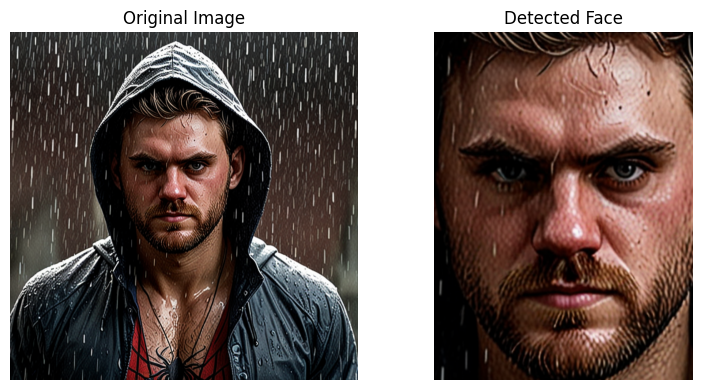

In [18]:
plot_og_and_face_image(df_train['file_path'][0])

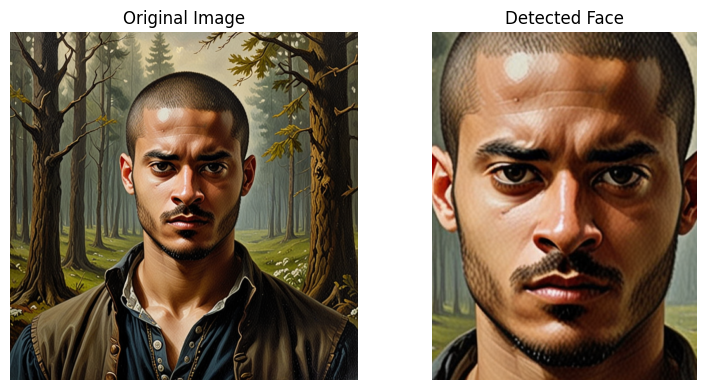

In [19]:
plot_og_and_face_image(df_train['file_path'][10], scale_factor=0.1)

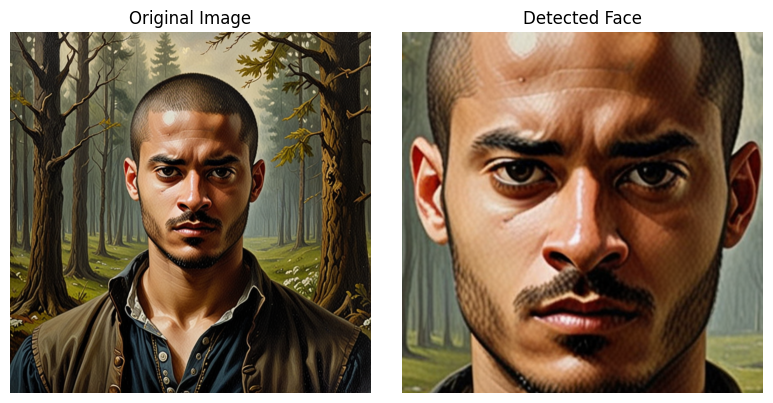

In [20]:
plot_og_and_face_image(df_train['file_path'][10], square=True)

FaceNet may fail to detect faces in some images. In such cases, I kept the original image unchanged. Let's check how many images had no detectable faces.

In [21]:
without_faces = []
shapes = []

for filename in tqdm(os.listdir(train_path)):
    if filename.endswith(".png") and filename.startswith("image_"):
        face, status = detect_face(os.path.join(train_path, filename), square=True)
        if status:
            shapes.append(face.shape)
        else:
            without_faces.append(filename)
        cv.imwrite(os.path.join(train_faces_path, filename), cv.cvtColor(face, cv.COLOR_RGB2BGR))

100%|██████████| 1800/1800 [07:01<00:00,  4.27it/s]


In [22]:
len(without_faces)

4

As we can see, only 4 out of 1800 images were affected. Let’s display them.


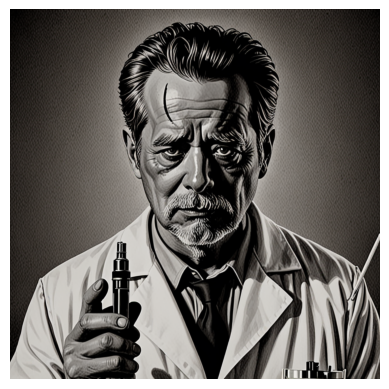

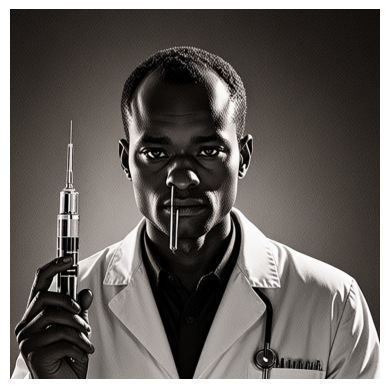

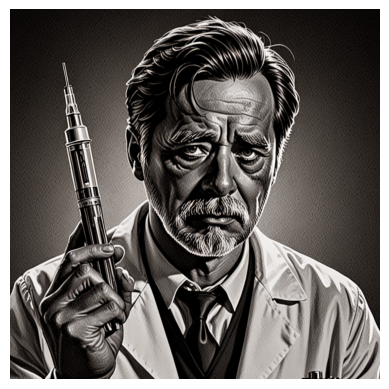

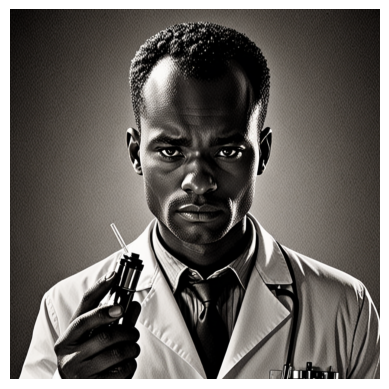

In [23]:
for image_path in without_faces:
    img = cv.imread(os.path.join(train_path, image_path))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


Next, we perform a duplicate check on the face-cropped images.

In [24]:
encodings_faces = phasher.encode_images(image_dir=train_faces_path)
duplicates_faces = phasher.find_duplicates(encoding_map=encodings_faces)

2025-04-15 18:52:33,868: INFO Start: Calculating hashes...
100%|██████████| 1800/1800 [00:04<00:00, 436.76it/s]
2025-04-15 18:52:38,370: INFO End: Calculating hashes!
/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/imagededup/methods/hashing.py:317: RuntimeWarning: Parameter num_enc_workers has no effect since encodings are already provided
  warnings.warn('Parameter num_enc_workers has no effect since encodings are already provided', RuntimeWarning)
2025-04-15 18:52:38,372: INFO Start: Evaluating hamming distances for getting duplicates
2025-04-15 18:52:38,373: INFO Start: Retrieving duplicates using Cython Brute force algorithm
100%|██████████| 1800/1800 [00:00<00:00, 2789.11it/s]
2025-04-15 18:52:39,330: INFO End: Retrieving duplicates using Cython Brute force algorithm
2025-04-15 18:52:39,330: INFO End: Evaluating hamming distances for getting duplicates


In [25]:
duplicates_faces_num = []
for key, val in duplicates_faces.items():
    duplicates_faces_num.append((len(val), key))
duplicates_faces_num = sorted(duplicates_faces_num)

duplicate_faces_files = set()
for _, file in duplicates_faces_num:
    if file not in duplicate_faces_files:
        duplicate_faces_files.update(duplicates_faces[file])

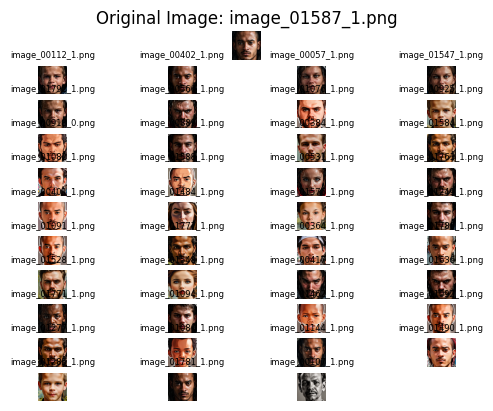

In [26]:
plot_duplicates(image_dir=train_faces_path,
                duplicate_map=duplicates_faces,
                filename=duplicates_faces_num[-1][1])

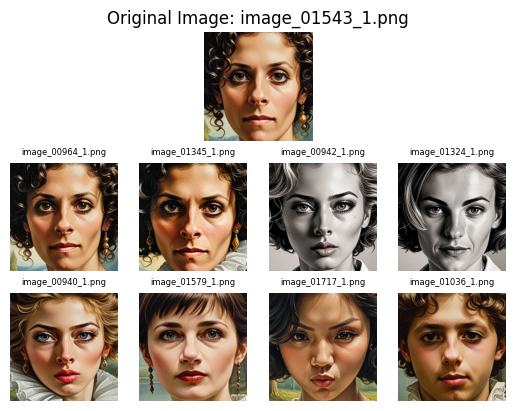

In [27]:
plot_duplicates(image_dir=train_faces_path,
                duplicate_map=duplicates_faces,
                filename=duplicates_faces_num[-100][1])

We observe that only one cluster contains a relatively large number of duplicates. However, even within this cluster, the images are not visually identical. Therefore, we can proceed with this dataset without performing additional duplicate removal.

# Datasets

The dataset class follows a standard structure for torch-based models. It handles reading images and applying augmentations. Additionally, there is a special mode for face-only datasets that generates missing cropped face images on-the-fly and reads from them if they exist.

In [65]:
class ArtefactDataset(Dataset):
    def __init__(self, image_paths: List[str], labels: List[int], 
                 transform: transforms.Compose | None = None, 
                 faces: bool = False, 
                 face_dir: str = "face_crops"):
        super().__init__()
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.faces = faces
        self.face_dir = face_dir

        if self.faces:
            os.makedirs(self.face_dir, exist_ok=True)
            self.image_paths = self._prepare_face_crops()

    def _prepare_face_crops(self) -> List[str]:
        face_image_paths = []

        for orig_path in tqdm(self.image_paths, desc="Detecting & Saving Faces"):
            filename = os.path.basename(orig_path)
            face_path = os.path.join(self.face_dir, filename)

            if not os.path.exists(face_path):
                face, status = detect_face(orig_path, square=True)
                if status == 1:
                    cv.imwrite(face_path, cv.cvtColor(face, cv.COLOR_RGB2BGR))
                else:
                    print(f"Warning: No face found in {filename}, copying original.")
                    img = cv.imread(orig_path)
                    cv.imwrite(face_path, img)

            face_image_paths.append(face_path)
        return face_image_paths

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index: int):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

In [29]:
file_paths = df_train['file_path'].values
labels = df_train['label'].values

file_train, file_val, label_train, label_val = train_test_split(
    file_paths,
    labels,
    test_size=0.1,
    stratify=labels,
    random_state=42
)


transform_train = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


transform_test = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [30]:
train_dataset = ArtefactDataset(image_paths=file_train, labels=label_train, transform=transform_train)
val_dataset   = ArtefactDataset(image_paths=file_val, labels=label_val, transform=transform_test)

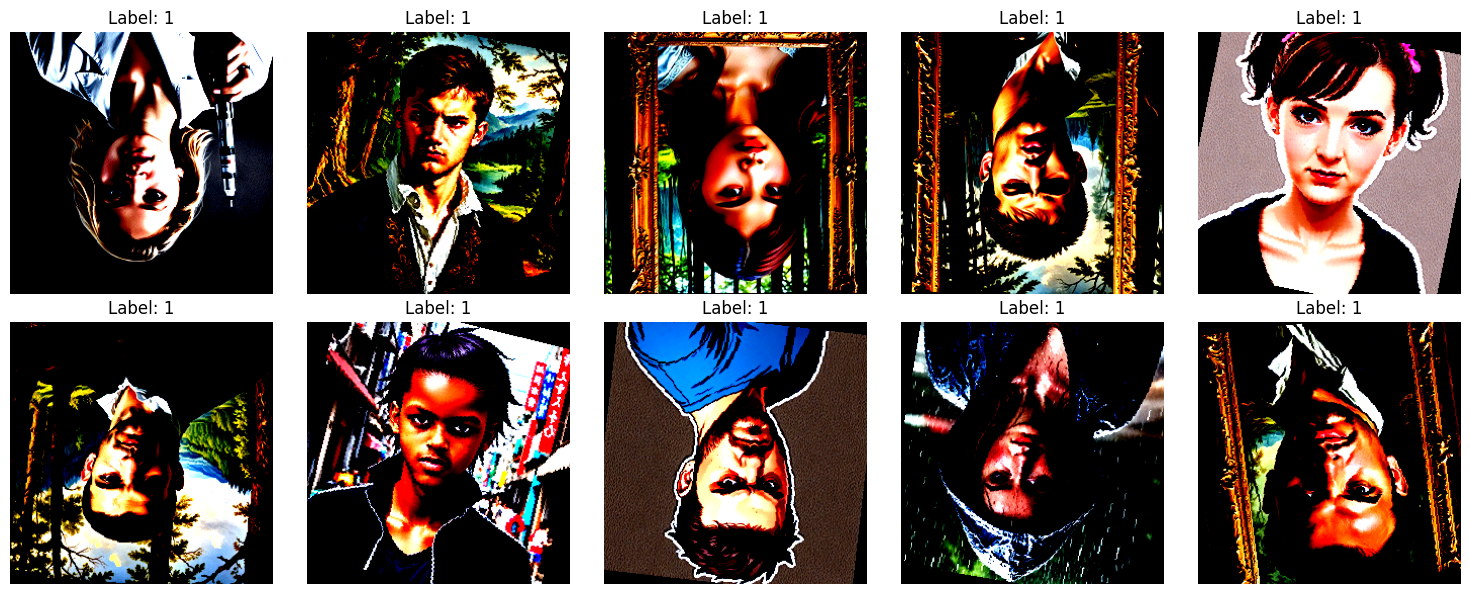

In [31]:
show_10_images(train_dataset)

# Modeling

In [32]:
VAL_SIZE: float = 0.2
IMAGE_SIZE: int = 300
DEPTH: int = 3

EPOCHS: int = 50
LEARNING_RATE: float = 3e-4
BATCH_SIZE: int = 8
DEVICE: str = "cuda"

#Model's weights paths
LOSS_BALANCING_PATH: str = "./weights/efficientnet_loss_balancing.pth"
OVERSAMPLING_PATH: str = "./weights/efficientnet_oversampling.pth"
FACES_MODEL_PATH: str = "./weights/efficientnet_faces.pth"

Given that this is a binary classification task—with the added challenge of a highly imbalanced dataset — I chose the EfficientNet architecture. EfficientNet is known for its strong performance in image classification tasks while maintaining a relatively low number of parameters compared to similar models.

I also slightly modified the final layer of the classifier so that the model outputs a single value. This design choice is motivated by the loss function selected for training, which will be discussed in the next section.

EfficientNet comes in several variants, denoted B0 to B7, where the index corresponds to increasing model size, input resolution, and classification performance. I chose the B3 version for two main reasons:
- Computational cost: While larger versions (B4–B7) offer slightly better results, the improvements are not significant enough to justify the increased computational cost. Given the limitations of my GPU, B3 provides a good balance between speed and performance. 

    ![image info](https://miro.medium.com/v2/resize:fit:4800/format:webp/0*7FRwXHm8zta7wHTk.png)

    [Source](https://arjun-sarkar786.medium.com/understanding-efficientnet-the-most-powerful-cnn-architecture-eaeb40386fad)

- Train image size: Since I plan to experiment with different training approaches on the same model, it’s important that the input resolution is compatible with all images. For the face-based images, the smallest dimensions are around 317x317, while the most of them are between 360–380 pixels. EfficientNet-B3 takes 300x300 images as input, whereas B4 requires 380x380. Therefore, B3 is the largest version I can reliably use for upscaled images without losing compatibility. 
    
    ![image info](https://discuss.pytorch.org/uploads/default/original/3X/e/6/e64d1baec60fff5e0c138eff2ff8cd63264dc87f.png)

In [33]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes: int = 1, depth: int = 3, infer_mode: bool = False):
        super().__init__()
        depth_models = {
            0: models.efficientnet_b0,
            1: models.efficientnet_b1,
            2: models.efficientnet_b2,
            3: models.efficientnet_b3,
            4: models.efficientnet_b4,
            5: models.efficientnet_b5,
            6: models.efficientnet_b6,
            7: models.efficientnet_b7,
        }

        self.infer_mode = infer_mode
        self.base_model = depth_models[depth](pretrained=True)
        head_in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(head_in_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        if self.infer_mode:
            x = 1 if torch.sigmoid(x) > 0.5 else 0
        return x

In [34]:
def train_step(train_loader: DataLoader, model: nn.Module, criterion: nn.Module, optimizer: torch.optim, epoch: int, total_epochs: int, device: str = "cuda") -> float:
    model.train()
    step_loss: float = 0.0

    for batch, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}"):
        labels = labels.view(-1, 1).float()
        batch, labels = batch.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        step_loss += loss.item()
    return step_loss / len(train_loader)    


def evaluate_model(test_loader: DataLoader, model: nn.Module, criterion: nn.Module | None = None, device: str = "cuda") -> Tuple[float, float]:
    model.to(device)
    model.eval()
    test_loss: float = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch, labels in tqdm(test_loader):
            batch, labels = batch.to(device), labels.to(device)

            outputs = model(batch)

            labels = labels.view(-1, 1)
            if criterion is not None:
                loss = criterion(outputs, labels.float())
                test_loss += loss.item()
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    return test_loss / len(test_loader), f1_micro


def train_model(model: nn.Module, 
                train_loader: DataLoader, 
                val_loader: DataLoader,
                criterion: nn.Module,
                optimizer: torch.optim,
                num_epochs: int,
                model_path: str,
                device: str):
    best_f1 = 0.0

    for epoch in range(num_epochs):
        train_loss = train_step(train_loader, model, criterion, optimizer, epoch, num_epochs, device)
        print(f"Train loss: {train_loss}")
        if (epoch + 1) % 2 == 0:
            val_loss, f1_micro = evaluate_model(val_loader, model, criterion, device)
            print(f"Val loss: {val_loss}, F1-micro: {f1_micro:.3f}")
            if f1_micro >= best_f1:
                best_f1 = f1_micro
                torch.save(model.state_dict(), model_path)
                if f1_micro > 0.99:
                    break
    return best_f1

# Training

I experimented with three different training methods, distinguished primarily by the type of input data:
- A s**tandard dataset without duplicates**
- A **dataset containing only cropped face images**, which includes all images from the standard dataset

For the standard dataset without duplicates, I applied two techniques to address class imbalance:
- **Loss balancing**: Applied class weights in the loss function so that the minority class contributes more strongly to the gradient updates.
- **Oversampling**: Modified the dataloader to increase the frequency of sampling from the minority class.

For the face-based dataset, I used only oversampling. (Spoiler alert: both methods performed similarly well on the standard dataset, so I chose to use just one method for the face-based dataset to reduce redundancy.)

Below is the code used to train all three variants. The structure is the same across all versions, with only a few parameter differences. Here's an overview of the pipeline:
- The training data is split into training and validation sets with an 80:20 ratio.
- The model evaluates micro F1-score on the validation set every two epochs, and the best-performing checkpoint is saved.
- The augmentations applied to the training images are relatively simple: light random rotations, horizontal and vertical flips, resizing to 300×300, and normalization.
- For the validation set, only resizing and normalization are applied.

The optimizer used is **Adam**, which provides a good balance of performance and simplicity. The loss function is **BCEWithLogitsLoss**, chosen for its compatibility with binary classification and its ability to incorporate class weights for balancing. In all three experiments, the same loss function was used, with the class weights reflecting the ratio of negative to positive samples.

## Without duplicates

In [35]:
file_paths = df_train_unique['file_path'].values
labels = df_train_unique['label'].values

file_train, file_val, label_train, label_val = train_test_split(
    file_paths,
    labels,
    test_size=VAL_SIZE,
    stratify=labels,
    random_state=42
)

transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ArtefactDataset(image_paths=file_train, labels=label_train, transform=transform_train)
val_dataset   = ArtefactDataset(image_paths=file_val, labels=label_val, transform=transform_test)
pos_class_num = sum(label_train)
neg_class_num = len(label_train) - pos_class_num

test_dataset = ArtefactDataset(df_test['file_path'].values, df_test['label'].values, transform_test)
test_loader = DataLoader(test_dataset, batch_size=1)

### Loss balancing

In [36]:
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1)

In [37]:
efficientnet = EfficientNet(depth=DEPTH).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([neg_class_num / pos_class_num]).float()).to(DEVICE)
optimizer = optim.Adam(params=efficientnet.parameters(), lr=LEARNING_RATE)

/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
best_f1 = train_model(model=efficientnet, 
                      train_loader=train_loader, 
                      val_loader=val_loader,
                      criterion=criterion,
                      optimizer=optimizer,
                      num_epochs=EPOCHS,
                      model_path=LOSS_BALANCING_PATH,
                      device=DEVICE)

Epoch 1/50: 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


Train loss: 0.16488311849534512


Epoch 2/50: 100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Train loss: 0.14360792446881532


100%|██████████| 199/199 [00:20<00:00,  9.86it/s]


Val loss: 0.19647801585434632, F1-micro: 0.698


Epoch 3/50: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


Train loss: 0.13774926979094743


Epoch 4/50: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


Train loss: 0.11679035723209381


100%|██████████| 199/199 [00:19<00:00,  9.98it/s]


Val loss: 0.07452113592257752, F1-micro: 0.854


Epoch 5/50: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Train loss: 0.09010652543976903


Epoch 6/50: 100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Train loss: 0.09115043738856912


100%|██████████| 199/199 [00:20<00:00,  9.88it/s]


Val loss: 0.07133562974257385, F1-micro: 0.859


Epoch 7/50: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


Train loss: 0.0728505827113986


Epoch 8/50: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


Train loss: 0.07594799061305821


100%|██████████| 199/199 [00:20<00:00,  9.87it/s]


Val loss: 0.05660398499033971, F1-micro: 0.955


Epoch 9/50: 100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


Train loss: 0.07024952907115221


Epoch 10/50: 100%|██████████| 100/100 [00:19<00:00,  5.18it/s]


Train loss: 0.06545069348998368


100%|██████████| 199/199 [00:20<00:00,  9.88it/s]


Val loss: 0.06848758850340268, F1-micro: 0.889


Epoch 11/50: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Train loss: 0.059168257312849165


Epoch 12/50: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


Train loss: 0.060202738456428054


100%|██████████| 199/199 [00:19<00:00, 10.31it/s]


Val loss: 0.0967464743125903, F1-micro: 0.774


Epoch 13/50: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Train loss: 0.03699168721213937


Epoch 14/50: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Train loss: 0.05934221144299954


100%|██████████| 199/199 [00:19<00:00, 10.35it/s]


Val loss: 0.05841841694990164, F1-micro: 0.910


Epoch 15/50: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Train loss: 0.05747492088936269


Epoch 16/50: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Train loss: 0.051462403191253545


100%|██████████| 199/199 [00:19<00:00, 10.31it/s]


Val loss: 0.06738778489967107, F1-micro: 0.894


Epoch 17/50: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Train loss: 0.04714498799759895


Epoch 18/50: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Train loss: 0.05294181779026985


100%|██████████| 199/199 [00:19<00:00, 10.32it/s]


Val loss: 0.05332602831149233, F1-micro: 0.930


Epoch 19/50: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Train loss: 0.039201303464360536


Epoch 20/50: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Train loss: 0.05328653308562934


100%|██████████| 199/199 [00:19<00:00, 10.33it/s]


Val loss: 0.0945677606519967, F1-micro: 0.844


Epoch 21/50: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Train loss: 0.03601223414996639


Epoch 22/50: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Train loss: 0.06285780211212114


100%|██████████| 199/199 [00:19<00:00, 10.32it/s]


Val loss: 0.06311279391280807, F1-micro: 0.955


Epoch 23/50: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Train loss: 0.039498042220948264


Epoch 24/50: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Train loss: 0.03667643777327612


100%|██████████| 199/199 [00:19<00:00, 10.39it/s]


Val loss: 0.040035846862287804, F1-micro: 0.980


Epoch 25/50: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Train loss: 0.036965839717304334


Epoch 26/50: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Train loss: 0.04755623296834528


100%|██████████| 199/199 [00:19<00:00, 10.41it/s]


Val loss: 0.03541910317754221, F1-micro: 0.975


Epoch 27/50: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Train loss: 0.02768449544411851


Epoch 28/50: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Train loss: 0.03376093658385798


100%|██████████| 199/199 [00:19<00:00, 10.39it/s]


Val loss: 0.03627660789712152, F1-micro: 0.995


In [39]:
efficientnet = EfficientNet(num_classes=1, depth=DEPTH)
efficientnet.load_state_dict(torch.load(LOSS_BALANCING_PATH))
efficientnet = efficientnet.to(DEVICE)
efficientnet.eval()

/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [40]:
_, f1_test = evaluate_model(test_loader, efficientnet)
print(f"Best Validation micro F1-score: {best_f1}")
print(f"Micro F1-score for test dataset: {f1_test}")

100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

Best Validation micro F1-score: 0.9949748743718593
Micro F1-score for test dataset: 0.955


### Oversampling

In [41]:
class_weights = {
    0: 1.0 / neg_class_num,
    1: 1.0 / pos_class_num
}

sample_weights = [class_weights[label] for label in label_train]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(label_train), replacement=True)
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          sampler=sampler,
                          num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1)

In [42]:
efficientnet = EfficientNet(num_classes=1, depth=DEPTH).to(DEVICE)
criterion = nn.BCEWithLogitsLoss().to(DEVICE)
optimizer = optim.Adam(params=efficientnet.parameters(), lr=LEARNING_RATE)

/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
best_f1 = train_model(model=efficientnet, 
                      train_loader=train_loader, 
                      val_loader=val_loader,
                      criterion=criterion,
                      optimizer=optimizer,
                      num_epochs=EPOCHS,
                      model_path=OVERSAMPLING_PATH,
                      device=DEVICE)

Epoch 1/50: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Train loss: 0.5309602220356464


Epoch 2/50: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Train loss: 0.34440802663564685


100%|██████████| 199/199 [00:19<00:00, 10.41it/s]


Val loss: 0.3909121138106882, F1-micro: 0.834


Epoch 3/50: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Train loss: 0.2837170618213713


Epoch 4/50: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Train loss: 0.22086396658793092


100%|██████████| 199/199 [00:19<00:00, 10.40it/s]


Val loss: 0.1391387012999848, F1-micro: 0.955


Epoch 5/50: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Train loss: 0.19950240774080158


Epoch 6/50: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Train loss: 0.1673084664158523


100%|██████████| 199/199 [00:19<00:00, 10.35it/s]


Val loss: 0.0843342782422197, F1-micro: 0.980


Epoch 7/50: 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


Train loss: 0.14748417406342923


Epoch 8/50: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Train loss: 0.19571449434384702


100%|██████████| 199/199 [00:19<00:00, 10.33it/s]


Val loss: 0.09167929187102555, F1-micro: 0.970


Epoch 9/50: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Train loss: 0.1416666528955102


Epoch 10/50: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Train loss: 0.13991691512055696


100%|██████████| 199/199 [00:19<00:00, 10.34it/s]


Val loss: 0.13744595555696681, F1-micro: 0.965


Epoch 11/50: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Train loss: 0.1414949810830876


Epoch 12/50: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Train loss: 0.10570215584710241


100%|██████████| 199/199 [00:19<00:00, 10.34it/s]


Val loss: 0.08463502593537586, F1-micro: 0.980


Epoch 13/50: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Train loss: 0.0935539184533991


Epoch 14/50: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Train loss: 0.13246112007647753


100%|██████████| 199/199 [00:19<00:00, 10.34it/s]


Val loss: 0.0858839126554063, F1-micro: 0.985


Epoch 15/50: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Train loss: 0.08503388189943507


Epoch 16/50: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Train loss: 0.12384605417959392


100%|██████████| 199/199 [00:19<00:00, 10.41it/s]


Val loss: 0.24280890665317997, F1-micro: 0.935


Epoch 17/50: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Train loss: 0.20816843673121185


Epoch 18/50: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Train loss: 0.14059052508324385


100%|██████████| 199/199 [00:19<00:00, 10.41it/s]


Val loss: 0.0834072353963435, F1-micro: 0.985


Epoch 19/50: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Train loss: 0.1368629550701007


Epoch 20/50: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Train loss: 0.08907861483050511


100%|██████████| 199/199 [00:19<00:00, 10.42it/s]


Val loss: 0.09808662773714023, F1-micro: 0.960


Epoch 21/50: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Train loss: 0.08937812161166221


Epoch 22/50: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Train loss: 0.05447509486577474


100%|██████████| 199/199 [00:19<00:00, 10.37it/s]


Val loss: 0.07931216863178418, F1-micro: 0.975


Epoch 23/50: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Train loss: 0.13059580632019788


Epoch 24/50: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Train loss: 0.16996254615020007


100%|██████████| 199/199 [00:19<00:00, 10.36it/s]


Val loss: 0.09456104892100639, F1-micro: 0.965


Epoch 25/50: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Train loss: 0.06979220881126821


Epoch 26/50: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Train loss: 0.05279928206698969


100%|██████████| 199/199 [00:19<00:00, 10.40it/s]


Val loss: 0.09482060214526379, F1-micro: 0.980


Epoch 27/50: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Train loss: 0.10800087487790734


Epoch 28/50: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Train loss: 0.05535966522351373


100%|██████████| 199/199 [00:19<00:00, 10.45it/s]


Val loss: 0.07996086298735737, F1-micro: 0.980


Epoch 29/50: 100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Train loss: 0.04754065088927746


Epoch 30/50: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Train loss: 0.07362763888319022


100%|██████████| 199/199 [00:19<00:00, 10.36it/s]


Val loss: 0.10674055043987941, F1-micro: 0.985


Epoch 31/50: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Train loss: 0.0406690319639165


Epoch 32/50: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Train loss: 0.0825315754514304


100%|██████████| 199/199 [00:19<00:00, 10.33it/s]


Val loss: 0.11437511229479608, F1-micro: 0.970


Epoch 33/50: 100%|██████████| 100/100 [00:19<00:00,  5.16it/s]


Train loss: 0.04353172776347492


Epoch 34/50: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Train loss: 0.0556340038345661


100%|██████████| 199/199 [00:19<00:00, 10.34it/s]


Val loss: 0.08993402586767768, F1-micro: 0.975


Epoch 35/50: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Train loss: 0.13072187449317427


Epoch 36/50: 100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


Train loss: 0.08372044118004851


100%|██████████| 199/199 [00:19<00:00, 10.35it/s]


Val loss: 0.12460687204329768, F1-micro: 0.970


Epoch 37/50: 100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


Train loss: 0.06289734307676553


Epoch 38/50: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Train loss: 0.09466427615261637


100%|██████████| 199/199 [00:19<00:00, 10.36it/s]


Val loss: 0.1134298295938848, F1-micro: 0.970


Epoch 39/50: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Train loss: 0.047132381846895444


Epoch 40/50: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Train loss: 0.0425308296084404


100%|██████████| 199/199 [00:19<00:00, 10.33it/s]


Val loss: 0.09886415019925218, F1-micro: 0.965


Epoch 41/50: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Train loss: 0.07576181708602235


Epoch 42/50: 100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


Train loss: 0.030709451202710625


100%|██████████| 199/199 [00:19<00:00, 10.35it/s]


Val loss: 0.10497986561614675, F1-micro: 0.980


Epoch 43/50: 100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


Train loss: 0.07729896429329529


Epoch 44/50: 100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


Train loss: 0.05144555736595066


100%|██████████| 199/199 [00:19<00:00, 10.44it/s]


Val loss: 0.02970704106290019, F1-micro: 0.995


In [44]:
efficientnet = EfficientNet(num_classes=1, depth=DEPTH)
efficientnet.load_state_dict(torch.load(OVERSAMPLING_PATH))
efficientnet = efficientnet.to(DEVICE)
efficientnet.eval()

/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [45]:
_, f1_test = evaluate_model(test_loader, efficientnet)
print(f"Best Validation micro F1-score: {best_f1}")
print(f"Micro F1-score for test dataset: {f1_test}")

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

Best Validation micro F1-score: 0.9949748743718593
Micro F1-score for test dataset: 0.945


## Classification using faces

In [46]:
file_paths = df_train['file_path'].values
labels = df_train['label'].values

file_train, file_val, label_train, label_val = train_test_split(
    file_paths,
    labels,
    test_size=VAL_SIZE,
    stratify=labels,
    random_state=42
)

In [47]:
train_dataset = ArtefactDataset(image_paths=file_train, 
                                labels=label_train, 
                                transform=transform_train, 
                                faces=True, 
                                face_dir="./trainee_dataset/train_faces")
val_dataset   = ArtefactDataset(image_paths=file_val, 
                                labels=label_val, 
                                transform=transform_test, 
                                faces=True, 
                                face_dir="./trainee_dataset/val_faces")
pos_class_num = sum(label_train)
neg_class_num = len(label_train) - pos_class_num

Detecting & Saving Faces: 100%|██████████| 360/360 [01:21<00:00,  4.39it/s]


In [48]:
class_weights = {
    0: 1.0 / neg_class_num,
    1: 1.0 / pos_class_num
}

sample_weights = [class_weights[label] for label in label_train]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(label_train), replacement=True)
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          sampler=sampler,
                          num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=1)

In [49]:
efficientnet = EfficientNet(num_classes=1, depth=DEPTH).to(DEVICE)
criterion = nn.BCEWithLogitsLoss().to(DEVICE)
optimizer = optim.Adam(params=efficientnet.parameters(), lr=LEARNING_RATE)

/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
best_f1 = train_model(model=efficientnet, 
                      train_loader=train_loader, 
                      val_loader=val_loader,
                      criterion=criterion,
                      optimizer=optimizer,
                      num_epochs=EPOCHS,
                      model_path=FACES_MODEL_PATH,
                      device=DEVICE)

Epoch 1/50: 100%|██████████| 180/180 [00:34<00:00,  5.25it/s]


Train loss: 0.4414439294901159


Epoch 2/50: 100%|██████████| 180/180 [00:34<00:00,  5.25it/s]


Train loss: 0.25720539500729905


100%|██████████| 360/360 [00:19<00:00, 18.50it/s]


Val loss: 0.18996239237923065, F1-micro: 0.936


Epoch 3/50: 100%|██████████| 180/180 [00:34<00:00,  5.26it/s]


Train loss: 0.22307816963228916


Epoch 4/50: 100%|██████████| 180/180 [00:34<00:00,  5.26it/s]


Train loss: 0.19068993381224572


100%|██████████| 360/360 [00:19<00:00, 18.39it/s]


Val loss: 0.12319129304627899, F1-micro: 0.961


Epoch 5/50: 100%|██████████| 180/180 [00:34<00:00,  5.26it/s]


Train loss: 0.19601654979503816


Epoch 6/50: 100%|██████████| 180/180 [00:34<00:00,  5.26it/s]


Train loss: 0.11749352657805301


100%|██████████| 360/360 [00:19<00:00, 18.58it/s]


Val loss: 0.13088907709459616, F1-micro: 0.958


Epoch 7/50: 100%|██████████| 180/180 [00:34<00:00,  5.25it/s]


Train loss: 0.12302209920663801


Epoch 8/50: 100%|██████████| 180/180 [00:34<00:00,  5.28it/s]


Train loss: 0.16891356118075135


100%|██████████| 360/360 [00:19<00:00, 18.64it/s]


Val loss: 0.12214236245441093, F1-micro: 0.964


Epoch 9/50: 100%|██████████| 180/180 [00:34<00:00,  5.28it/s]


Train loss: 0.12140283625469439


Epoch 10/50: 100%|██████████| 180/180 [00:33<00:00,  5.31it/s]


Train loss: 0.12146200038130499


100%|██████████| 360/360 [00:19<00:00, 18.42it/s]


Val loss: 0.19482983070627402, F1-micro: 0.947


Epoch 11/50: 100%|██████████| 180/180 [00:34<00:00,  5.26it/s]


Train loss: 0.08942244969592947


Epoch 12/50: 100%|██████████| 180/180 [00:34<00:00,  5.26it/s]


Train loss: 0.11773091054702592


100%|██████████| 360/360 [00:19<00:00, 18.53it/s]


Val loss: 0.16966301650327847, F1-micro: 0.961


Epoch 13/50: 100%|██████████| 180/180 [00:34<00:00,  5.26it/s]


Train loss: 0.07243173886090518


Epoch 14/50: 100%|██████████| 180/180 [00:34<00:00,  5.29it/s]


Train loss: 0.0863617925102719


100%|██████████| 360/360 [00:19<00:00, 18.63it/s]


Val loss: 0.14829299506698235, F1-micro: 0.964


Epoch 15/50: 100%|██████████| 180/180 [00:34<00:00,  5.29it/s]


Train loss: 0.07257335234511023


Epoch 16/50: 100%|██████████| 180/180 [00:34<00:00,  5.29it/s]


Train loss: 0.04981023081167627


100%|██████████| 360/360 [00:19<00:00, 18.37it/s]


Val loss: 0.2307517221981476, F1-micro: 0.972


Epoch 17/50: 100%|██████████| 180/180 [00:34<00:00,  5.25it/s]


Train loss: 0.07132463450155531


Epoch 18/50: 100%|██████████| 180/180 [00:34<00:00,  5.26it/s]


Train loss: 0.12781300910606255


100%|██████████| 360/360 [00:19<00:00, 18.37it/s]


Val loss: 0.11112718070943023, F1-micro: 0.975


Epoch 19/50: 100%|██████████| 180/180 [00:34<00:00,  5.29it/s]


Train loss: 0.09696012966612923


Epoch 20/50: 100%|██████████| 180/180 [00:33<00:00,  5.30it/s]


Train loss: 0.04961215993324812


100%|██████████| 360/360 [00:19<00:00, 18.32it/s]


Val loss: 0.14091278738055427, F1-micro: 0.969


Epoch 21/50: 100%|██████████| 180/180 [00:33<00:00,  5.30it/s]


Train loss: 0.04876304514230772


Epoch 22/50: 100%|██████████| 180/180 [00:34<00:00,  5.29it/s]


Train loss: 0.07313166339137954


100%|██████████| 360/360 [00:19<00:00, 18.30it/s]


Val loss: 0.11967756069513731, F1-micro: 0.958


Epoch 23/50: 100%|██████████| 180/180 [00:34<00:00,  5.26it/s]


Train loss: 0.0629861061016628


Epoch 24/50: 100%|██████████| 180/180 [00:34<00:00,  5.26it/s]


Train loss: 0.09074930334399041


100%|██████████| 360/360 [00:19<00:00, 18.52it/s]


Val loss: 0.22281378808841687, F1-micro: 0.961


Epoch 25/50: 100%|██████████| 180/180 [00:34<00:00,  5.25it/s]


Train loss: 0.06374390675466404


Epoch 26/50: 100%|██████████| 180/180 [00:34<00:00,  5.25it/s]


Train loss: 0.08198192252861594


100%|██████████| 360/360 [00:19<00:00, 18.48it/s]


Val loss: 0.17150131443577718, F1-micro: 0.953


Epoch 27/50: 100%|██████████| 180/180 [00:34<00:00,  5.25it/s]


Train loss: 0.0752575900169581


Epoch 28/50: 100%|██████████| 180/180 [00:34<00:00,  5.25it/s]


Train loss: 0.06909041358352018


100%|██████████| 360/360 [00:19<00:00, 18.60it/s]


Val loss: 0.20342966011898891, F1-micro: 0.961


Epoch 29/50: 100%|██████████| 180/180 [00:33<00:00,  5.35it/s]


Train loss: 0.03567255051344142


Epoch 30/50: 100%|██████████| 180/180 [00:59<00:00,  3.03it/s]


Train loss: 0.028404402036944196


100%|██████████| 360/360 [00:20<00:00, 17.41it/s]


Val loss: 0.13219633647911955, F1-micro: 0.975


Epoch 31/50: 100%|██████████| 180/180 [00:31<00:00,  5.75it/s]


Train loss: 0.06717269995731638


Epoch 32/50: 100%|██████████| 180/180 [00:31<00:00,  5.73it/s]


Train loss: 0.08346786067591488


100%|██████████| 360/360 [00:20<00:00, 17.51it/s]


Val loss: 0.17991881671614188, F1-micro: 0.972


Epoch 33/50: 100%|██████████| 180/180 [00:31<00:00,  5.71it/s]


Train loss: 0.1654634813086078


Epoch 34/50: 100%|██████████| 180/180 [00:32<00:00,  5.62it/s]


Train loss: 0.13726223459040435


100%|██████████| 360/360 [00:23<00:00, 15.49it/s]


Val loss: 0.10003659282047697, F1-micro: 0.972


Epoch 35/50: 100%|██████████| 180/180 [00:32<00:00,  5.61it/s]


Train loss: 0.06485593383291012


Epoch 36/50: 100%|██████████| 180/180 [00:34<00:00,  5.28it/s]


Train loss: 0.07773082562554111


100%|██████████| 360/360 [00:23<00:00, 15.41it/s]


Val loss: 0.13357263063910263, F1-micro: 0.972


Epoch 37/50: 100%|██████████| 180/180 [00:34<00:00,  5.19it/s]


Train loss: 0.04181055224891882


Epoch 38/50: 100%|██████████| 180/180 [00:33<00:00,  5.40it/s]


Train loss: 0.040037644640607245


100%|██████████| 360/360 [00:21<00:00, 16.93it/s]


Val loss: 0.1276469966660284, F1-micro: 0.958


Epoch 39/50: 100%|██████████| 180/180 [00:32<00:00,  5.49it/s]


Train loss: 0.046643674583255135


Epoch 40/50: 100%|██████████| 180/180 [00:32<00:00,  5.56it/s]


Train loss: 0.11799141375166881


100%|██████████| 360/360 [00:21<00:00, 17.09it/s]


Val loss: 0.13055021065665784, F1-micro: 0.961


Epoch 41/50: 100%|██████████| 180/180 [00:32<00:00,  5.50it/s]


Train loss: 0.06200304271608022


Epoch 42/50: 100%|██████████| 180/180 [00:33<00:00,  5.45it/s]


Train loss: 0.030060376746890445


100%|██████████| 360/360 [00:20<00:00, 17.39it/s]


Val loss: 0.14401004441426074, F1-micro: 0.978


Epoch 43/50: 100%|██████████| 180/180 [00:32<00:00,  5.51it/s]


Train loss: 0.018209138162880358


Epoch 44/50: 100%|██████████| 180/180 [00:33<00:00,  5.44it/s]


Train loss: 0.05199103489398516


100%|██████████| 360/360 [00:21<00:00, 17.01it/s]


Val loss: 0.15943597679396077, F1-micro: 0.969


Epoch 45/50: 100%|██████████| 180/180 [00:33<00:00,  5.44it/s]


Train loss: 0.02919894355881196


Epoch 46/50: 100%|██████████| 180/180 [00:33<00:00,  5.40it/s]


Train loss: 0.03656561220575693


100%|██████████| 360/360 [00:21<00:00, 16.80it/s]


Val loss: 0.18007202595741892, F1-micro: 0.969


Epoch 47/50: 100%|██████████| 180/180 [00:32<00:00,  5.51it/s]


Train loss: 0.04536530162149575


Epoch 48/50: 100%|██████████| 180/180 [00:32<00:00,  5.50it/s]


Train loss: 0.013036158502088963


100%|██████████| 360/360 [00:21<00:00, 16.80it/s]


Val loss: 0.2847109322279948, F1-micro: 0.961


Epoch 49/50: 100%|██████████| 180/180 [00:32<00:00,  5.46it/s]


Train loss: 0.05535268778104283


Epoch 50/50: 100%|██████████| 180/180 [00:32<00:00,  5.46it/s]


Train loss: 0.042378840047523327


100%|██████████| 360/360 [00:21<00:00, 16.72it/s]

Val loss: 0.1599249535255669, F1-micro: 0.972


In [51]:
efficientnet = EfficientNet(num_classes=1, depth=DEPTH)
efficientnet.load_state_dict(torch.load(FACES_MODEL_PATH))
efficientnet = efficientnet.to(DEVICE)
efficientnet.eval()

/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [52]:
test_dataset = ArtefactDataset(image_paths=df_test["file_path"].values, 
                               labels=df_test["label"].values, 
                               transform=transform_train, 
                               faces=True, 
                               face_dir="./trainee_dataset/test_faces")
test_loader = DataLoader(test_dataset, batch_size=1)

Detecting & Saving Faces: 100%|██████████| 200/200 [00:53<00:00,  3.77it/s]


In [53]:
_, f1_test = evaluate_model(test_loader, efficientnet)
print(f"Best Validation micro F1-score: {best_f1}")
print(f"Micro F1-score for test dataset: {f1_test}")

100%|██████████| 200/200 [00:11<00:00, 16.96it/s]

Best Validation micro F1-score: 0.9777777777777777
Micro F1-score for test dataset: 0.97


# Results

We begin by loading the weights of all three models and computing the micro F1-score on both the training and test datasets.

In [54]:
efficientnet_lossbalancing = EfficientNet(num_classes=1, depth=DEPTH)
efficientnet_lossbalancing.load_state_dict(torch.load(LOSS_BALANCING_PATH))
efficientnet_lossbalancing = efficientnet_lossbalancing.to(DEVICE)
efficientnet_lossbalancing.eval()

efficientnet_oversampling = EfficientNet(num_classes=1, depth=DEPTH)
efficientnet_oversampling.load_state_dict(torch.load(OVERSAMPLING_PATH))
efficientnet_oversampling = efficientnet_oversampling.to(DEVICE)
efficientnet_oversampling.eval()

efficientnet_faces = EfficientNet(num_classes=1, depth=DEPTH)
efficientnet_faces.load_state_dict(torch.load(FACES_MODEL_PATH))
efficientnet_faces = efficientnet_faces.to(DEVICE)
efficientnet_faces.eval()

/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/artur/files/IT-jim/Task_1/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (s

In [55]:
transform_image = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = ArtefactDataset(image_paths=df_train['file_path'].values, 
                                labels=df_train['label'].values, 
                                transform=transform_image)
test_dataset =  ArtefactDataset(image_paths=df_test['file_path'].values, 
                                labels=df_test['label'].values, 
                                transform=transform_image)

train_dataset_faces = ArtefactDataset(image_paths=df_train['file_path'].values, 
                                      labels=df_train['label'].values, 
                                      transform=transform_image, 
                                      faces=True, 
                                      face_dir="./trainee_dataset/train_faces")
test_dataset_faces  = ArtefactDataset(image_paths=df_test["file_path"].values, 
                                      labels=df_test["label"].values, 
                                      transform=transform_image, 
                                      faces=True, 
                                      face_dir="./trainee_dataset/test_faces")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
train_faces_loader = DataLoader(train_dataset_faces, batch_size=1, shuffle=False)
test_faces_loader = DataLoader(test_dataset_faces, batch_size=1, shuffle=False)

Detecting & Saving Faces: 100%|██████████| 200/200 [00:00<00:00, 93341.58it/s]


In [56]:
model_names: List[str] = ["Loss Balancing", "Oversampling", "Faces"]
models: List[nn.Module] = [efficientnet_lossbalancing, efficientnet_oversampling, efficientnet_faces]
train_scores: List[float] = []
test_scores: List[float] = []

for model_name, model in zip(model_names, models):
    print(f"{model_name} EfficientNet inferencing")
    if model_name != "Faces":
        _, f1_train = evaluate_model(train_loader, model)
        _, f1_test  = evaluate_model(test_loader, model)
    else:
        _, f1_train = evaluate_model(train_faces_loader, model)
        _, f1_test  = evaluate_model(test_faces_loader, model)
    train_scores.append(f1_train)
    test_scores.append(f1_test)

Loss Balancing EfficientNet inferencing


100%|██████████| 200/200 [00:20<00:00,  9.53it/s]


Oversampling EfficientNet inferencing


100%|██████████| 200/200 [00:20<00:00,  9.68it/s]


Faces EfficientNet inferencing


100%|██████████| 200/200 [00:11<00:00, 16.86it/s]


Next, we construct an ensemble model using a majority voting strategy, and evaluate whether it improves overall performance.

In [57]:
def evaluate_ensemble(data_loader: DataLoader, faces_data_loader: DataLoader, device: str = "cuda") -> Tuple[float, np.ndarray, np.ndarray]:
    efficientnet_lossbalancing.eval()
    efficientnet_oversampling.eval()
    efficientnet_faces.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for (batch, label), (batch_faces, _) in tqdm(zip(data_loader, faces_data_loader)):
            batch, batch_faces, label = batch.to(device), batch_faces.to(device), label.numpy()[0]

            output1 = efficientnet_lossbalancing(batch)
            output2 = efficientnet_oversampling(batch)
            output3 = efficientnet_faces(batch_faces)

            label = label
            pred_sum = (
                (torch.sigmoid(output1) > 0.5).float() +
                (torch.sigmoid(output2) > 0.5).float() +
                (torch.sigmoid(output3) > 0.5).float()
            )

            all_preds.append(1 if pred_sum > 1.5 else 0)
            all_labels.append(label)

    all_preds = np.array(all_preds)
    all_labels = np.array(np.array(all_labels))
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    return f1_micro, all_preds, all_labels

Before executing the ensemble inference, we ensure that both datasets use the same image order so that all models make predictions on the same inputs. To this end, the dataloaders were configured with `shuffle=False`.

In [58]:
train_filenames = np.array([os.path.basename(p) for p in train_dataset.image_paths])
train_faces_filenames = np.array([os.path.basename(p) for p in train_dataset_faces.image_paths])

matches = np.all(train_filenames == train_faces_filenames)
print(matches)

True


In [59]:
f1_ensemble_train, _, _ = evaluate_ensemble(train_loader, train_faces_loader)
f1_ensemble_test, predicts, labels = evaluate_ensemble(test_loader, test_faces_loader)

model_names.append("Ensemble")
train_scores.append(f1_ensemble_train)
test_scores.append(f1_ensemble_test)

1800it [06:13,  4.83it/s]
200it [00:41,  4.83it/s]


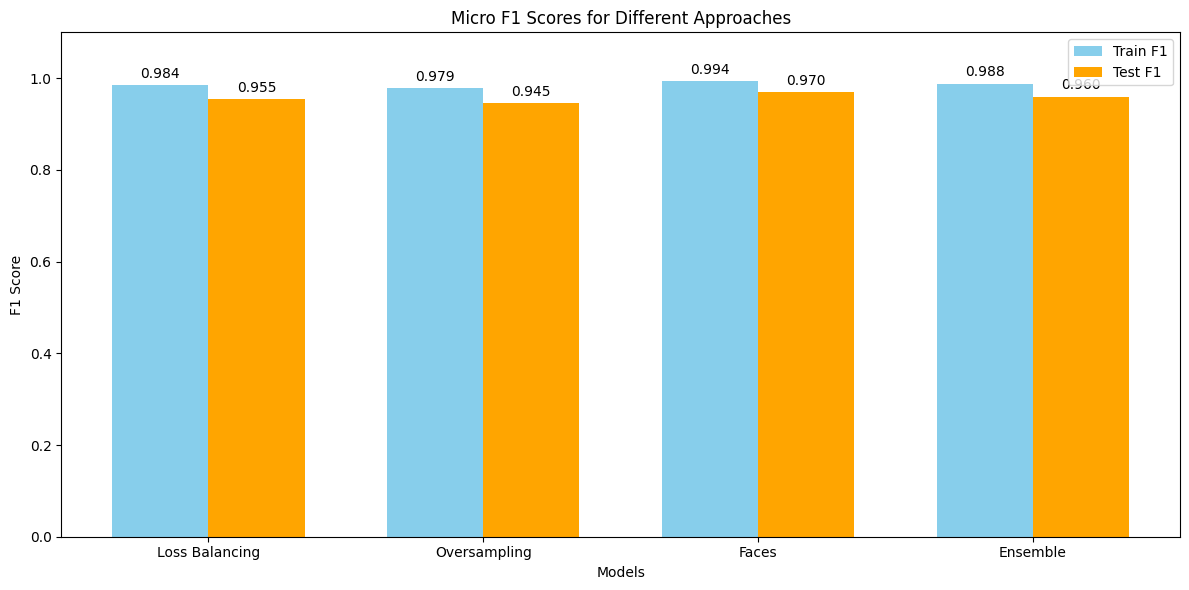

In [60]:
x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width/2, train_scores, width, label='Train F1', color='skyblue')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test F1', color='orange')

ax.set_xlabel('Models')
ax.set_ylabel('F1 Score')
ax.set_title("Micro F1 Scores for Different Approaches")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

Among all individual approaches, the **oversampling strategy** yielded strong results. However, the model trained on **face-cropped images** achieved the best performance, reaching a micro F1-score of **0.97**.

Interestingly, the **ensemble model underperformed slightly**. Upon closer inspection, this appears to be due to the fact that both the loss-balanced and oversampled models made incorrect predictions in the same instances, thereby negatively affecting the majority vote. This suggests that, in this particular case, ensembling did not lead to a performance gain, possibly due to correlated errors among the models.

Let's take a look at which images the ensemble got wrong.

In [61]:
diff_indices = np.where(predicts != labels)[0]

In [62]:
def show_mismatched_images(image_paths, labels, predicts, n=10):
    labels = np.array(labels).squeeze()
    predicts = np.array(predicts).squeeze()

    diff_indices = np.where(labels != predicts)[0]
    print(f"Found {len(diff_indices)} mismatches.")

    for i, idx in enumerate(diff_indices[:n]):
        img = Image.open(image_paths[idx])
        plt.subplot(1, min(n, 5), i % 5 + 1)
        plt.imshow(img)
        plt.title(f"True: {labels[idx]}\nPred: {predicts[idx]}")
        plt.axis("off")

        if (i + 1) % 5 == 0 or i == n - 1:
            plt.tight_layout()
            plt.show()


Found 8 mismatches.


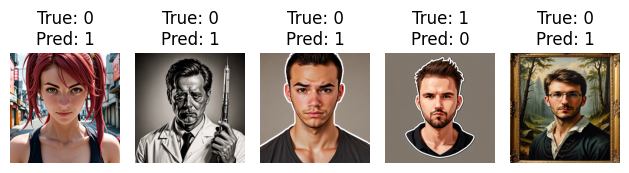

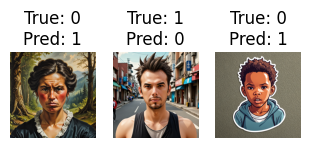

In [63]:
show_mismatched_images(train_dataset.image_paths, labels, predicts)

We observe that most misclassifications occur on images from the minority class, where the artifacts are subtle and less visually apparent—unlike the more obvious cases such as extra objects on the head.

This suggests that the challenges related to data imbalance and image duplication were largely addressed; however, there is still room for improvement. The errors made by the model often involve images with very small or subtle artifacts, which may not be easily captured by a general-purpose classification model.

To better detect such fine details, it may be beneficial to incorporate a specialized model trained specifically for fine-grained facial feature analysis. Combining such a model with EfficientNet could potentially yield even better results, possibly approaching a micro F1-score of 1.0.